<a href="https://www.kaggle.com/code/tejasurya/wind-power-eda-timeseries-forecasting?scriptVersionId=100001310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:#228b22;color:white;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid #228b22">⚡Wind power generation🔋EDA,Timeseries Forecasting</p>

<center><img src= "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTeo6sNuQjhCBQ8puCMXNfoEecFo_DjGsy3uRAXBZdZvzgXZZUjxmphHZPGMLx5zDj_pZw&usqp=CAU" alt ="wind-mills" style='width:500px;'></center>

<span style="color:#228b22;background-color:white;font-size:22px">Quick Navigation</span> <a id=2></a> <br>

1. [Introduction](#1) <br>

2. [Objective](#2) <br>

3. [EDA](#3) <br>

4. [Outlier Detection](#4) <br>

5. [Feature Engineering](#5) <br>
    
    5.1 [Lagging features](#5.1)<br>
    
    5.2 [Partial AutoCorrelation](#5.2)<br>

6. [Modelling](#6) <br>

    6.1 [Crossvalidation](#6.1) <br>
    
    6.2 [Lasso](#6.1.1) <br>

    6.3 [Lightgbm](#6.2) <br>

    6.4 [CatBoost](#6.3) <br>

    6.5 [Forecast results](#6.4) <br>

<span style="color:#228b22;background-color:white;font-size:22px">Introduction</span> <a id=2></a> <br> <a id = 1></a>

Wind power is a popular, sustainable, renewable energy source that has a much smaller impact on the environment than burning fossil fuels. Historically, wind power has been used in sails, windmills and windpumps but today it is mostly used to generate electricity. Wind mills are one of the most important form of renewable energy exploitation, generating electricity both on land (onshore) and in the open sea (offshore). Wind farms consist of many individual wind turbines, which are connected to the electric power transmission network.

New onshore (on-land) wind farms are cheaper than new coal or gas plants, but expansion of wind power is being hindered by fossil fuel subsidies. Onshore wind farms have a greater visual impact on the landscape than some other power stations. Small onshore wind farms can feed some energy into the grid or provide power to isolated off-grid locations. Offshore wind farms provide a steadier and stronger source of energy and have less visual impact. Although there is less offshore wind power at present and construction and maintenance costs are higher, it is expanding.

Wind power is variable renewable energy, so power-management techniques are used to match supply and demand. [Read more on this](https://en.wikipedia.org/wiki/Wind_power)

<br>

<span style="color:#228b22;background-color:white;font-size:22px">Objective</span> <a id=2></a> <br> 
To forecast the power generated from wind mills in Germany.

<br>
<span style="color:#228b22;background-color:white;font-size:22px">Data Description</span><br>
The Wind power dataset consists of a datapoint for `every 15 minutes` (according to Indian standard). So as we consider a datapoint corresponding to a timeblock, 1 hour will have 4 timeblocks and `1 day => 96 timeblocks`.

In the Power generation dataset we have 2 columns
* `datetime` 
    * datetime column is split for every 15 minutes. 
* `power(MW)`
    * For every 15 minutes there is a power(MW) value recorded.

<span style="color:#228b22;background-color:white;font-size:22px">Importing libraries</span> <a id=2.1></a> <br>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor as lgr
import lightgbm as lgb
from catboost import CatBoostRegressor as cbr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso,LinearRegression,Ridge,ElasticNet
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV , StratifiedKFold
from sklearn.metrics import explained_variance_score,r2_score,mean_squared_error,mean_absolute_error

In [2]:
wind_df = pd.read_csv('../input/wind-power/data.csv')

In [3]:
wind_df.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [4]:
wind_df.tail(10)

,dt,MW
385556,2021-12-30 05:30:00,8240.12
385557,2021-12-30 05:45:00,8361.77
385558,2021-12-30 06:00:00,8530.69
385559,2021-12-30 06:15:00,8603.80
385560,2021-12-30 06:30:00,8412.88
385561,2021-12-30 06:45:00,8140.31
385562,2021-12-30 07:00:00,8162.33
385563,2021-12-30 07:15:00,8405.11
385564,2021-12-30 07:30:00,8503.48
385565,2021-12-30 07:45:00,8403.53


<span style="color:#228b22;background-color:white;font-size:22px">shape</span> <a id=2></a> <br>

In [5]:
wind_df.shape

(385566, 2)

<span style="color:#228b22;background-color:white;font-size:22px">Basic Statistics</span> <a id=2></a> <br>

In [6]:
wind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [7]:
wind_df.rename(columns={'dt':'datetime','MW':'power'},inplace=True)
wind_df['datetime'] = pd.to_datetime(wind_df['datetime'])
wind_df['power'] = wind_df['power'].astype('float64')
wind_df.dtypes

datetime    datetime64[ns]
power              float64
dtype: object

<span style="color:#228b22;background-color:white;font-size:22px">Duration of Dataset</span> <a id=2></a> <br>

In [8]:
print(f'The data is available from {wind_df.datetime.min()} to {wind_df.datetime.max()}')

The data is available from 2011-01-01 00:00:00 to 2021-12-30 07:45:00


In [9]:
days = wind_df.shape[0]//96
print(f'The number of days of wind power in the dataset is {days}')

The number of days of wind power in the dataset is 4016


**Remark**:
* Here we divided by 96 because this dataset has 1 datapoint for every 15 minutes. 
* 4 datapoints in an hour and 4*24 = `96` datapoints per day.

In [10]:
wind_df.describe()

,power
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [11]:
print(f' The maximum power generated was on \n{wind_df.loc[wind_df.power==wind_df.power.max()]}')

 The maximum power generated was on 
                  datetime    power
378846 2021-10-21 09:00:00  16727.5


<span style="color:#FF0000;background-color:white;font-size:22px">Observation</span>  <br>
* The average power generation over years is `3183.56 MW` 
* The maximum power generation is `16727 MW` on `21-10-2021 @ 09:00:00`. 

In [12]:
wind_df.isna().sum()

datetime    0
power       0
dtype: int64

* No missing values in the dataset.

<h2 style="color:#228b22;background-color:white;font-size:22px">EDA</h2> <a id=3></a> <br> 

In [13]:
tb = np.arange(1,wind_df.shape[0]+1)
wind_df['tb'] = tb

In [14]:
wind_df['weekday'] = wind_df['datetime'].dt.day_name()
wind_df['month'] = wind_df['datetime'].dt.month_name()
wind_df['year'] = wind_df['datetime'].dt.year.astype('string')
wind_df['hour'] = wind_df['datetime'].dt.strftime('%H').astype('string')

In [15]:
wind_df

,datetime,power,tb,weekday,month,year,hour
0,2011-01-01 00:00:00,3416.00,1,Saturday,January,2011,00
1,2011-01-01 00:15:00,4755.00,2,Saturday,January,2011,00
2,2011-01-01 00:30:00,4939.00,3,Saturday,January,2011,00
3,2011-01-01 00:45:00,4939.00,4,Saturday,January,2011,00
4,2011-01-01 01:00:00,4998.00,5,Saturday,January,2011,01
...,...,...,...,...,...,...,...
385561,2021-12-30 06:45:00,8140.31,385562,Thursday,December,2021,06
385562,2021-12-30 07:00:00,8162.33,385563,Thursday,December,2021,07
385563,2021-12-30 07:15:00,8405.11,385564,Thursday,December,2021,07
385564,2021-12-30 07:30:00,8503.48,385565,Thursday,December,2021,07


In [16]:
wind_df.weekday.unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

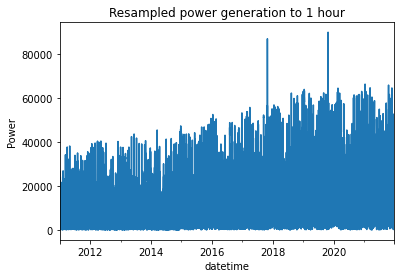

In [17]:
group_df = (wind_df.set_index('datetime')).resample('H')['power'].sum()
group_df.plot(kind='line')
plt.ylabel('Power')
plt.title('Resampled power generation to 1 hour')
plt.show()

* The year `2017` and `2019` have the huge spike in the power generated per hour

In [18]:
wind_df.rename(columns={'power':"power"},inplace=True)

<span style="color:#228b22;background-color:white;font-size:22px">Yearly Power generation pattern</span> <a id=2></a> <br> 

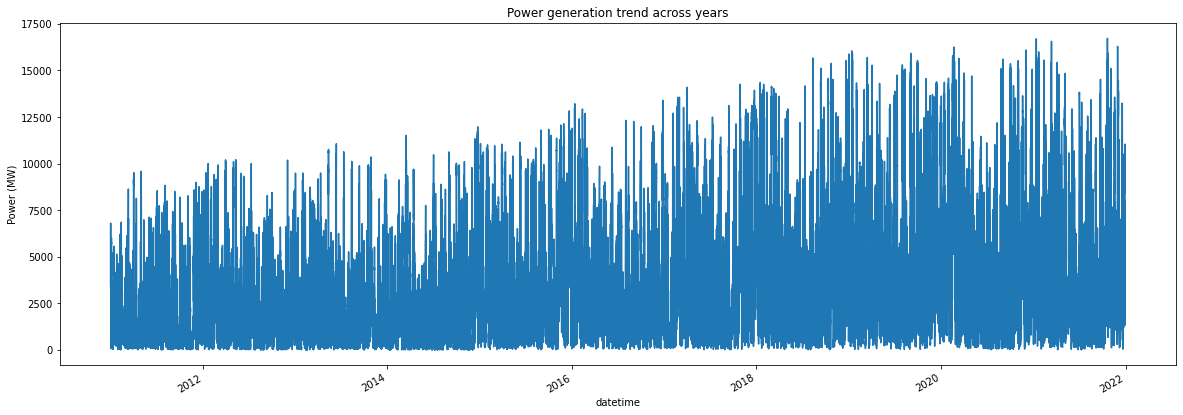

In [19]:
fig , axes = plt.subplots(1,1,figsize=(20,7))
wind_df.set_index('datetime')['power'].plot()
plt.ylabel('Power (MW)')
plt.title('Power generation trend across years')
plt.show()

<span style="color:#228b22;background-color:white;font-size:22px">Yearly Power increase</span> <a id=2></a> <br>

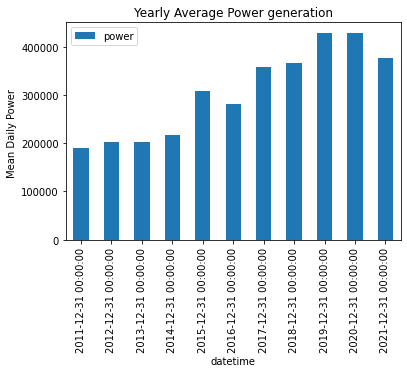

In [20]:
year_df = pd.DataFrame(wind_df.set_index('datetime').resample('1D')['power'].sum()).resample('1Y').mean()
year_df.plot.bar()
plt.title("Yearly Average Power generation")
plt.ylabel("Mean Daily Power ")
plt.show()

<span style="color:#FF0000;background-color:white;font-size:15px">Observation</span> <br> 
The power generation has been maximum in `2019` and `2020`.

<span style="color:#228b22;background-color:white;font-size:22px"> Weekly trend across years</span> <a id=2></a> <br>

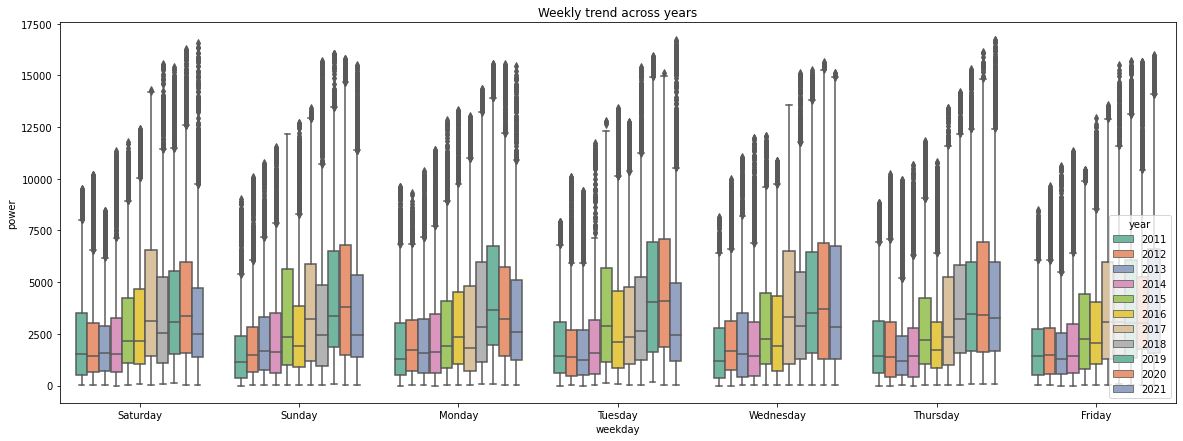

In [21]:
fig,axes = plt.subplots(1,1,figsize=(20,7))
sns.boxplot(data = wind_df,x='weekday',y='power',hue='year',palette='Set2',ax=axes)
plt.title('Weekly trend across years')
plt.show()

<span style="color:#FF0000;background-color:white;font-size:15px">Observation</span> <br> 
* The overall sum of power generated on Tuesday, Thursday, Friday, Saturday was high in the year 2021
* The overall sum of power generated on Monday, Sunday was high in the year 2019.

<span style="color:#228b22;background-color:white;font-size:22px">Yearly Growth in Power generation</span> <a id=2></a> <br> 

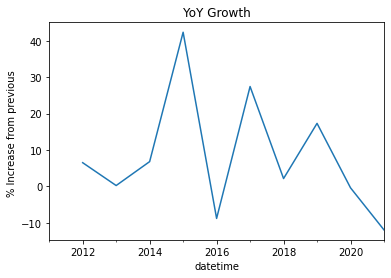

In [22]:
year_df = pd.DataFrame(wind_df.set_index('datetime').resample('1D')['power'].sum()).resample("1Y").mean()
year_df['shifted'] = year_df.shift(1)
year_df['YoYGrowth'] = ((year_df['power'] - year_df['shifted'])/year_df['shifted'])*100
year_df['YoYGrowth'].plot()
plt.title("YoY Growth")
plt.ylabel("% Increase from previous ")
plt.show()

<span style="color:#FF0000;background-color:white;font-size:15px">Observation</span> <br> 
* The year `2015` and `2017` have the highest percentage `increase` in the power compared to the previous year by `35%`.

<h2 style="color:#228b22;background-color:white;font-size:22px">Outlier detection</h2> <a id=4></a> <br> 

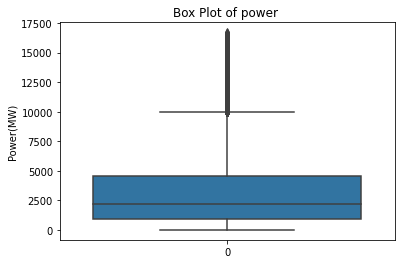

In [23]:
sns.boxplot(data=wind_df['power'])
plt.title('Box Plot of power ')
plt.ylabel('Power(MW)')
plt.show()

<span style="color:#FF0000;background-color:white;font-size:22px">Observation</span> <br> 
* From the box plot, the Power value above `10000 MW` are  outliers.

In [24]:
# As there are no outliers present users can select any one method to show  the same  
Q1= wind_df.power.quantile(0.25) 
Q3= wind_df.power.quantile(0.75) 
IQR = Q3-Q1
wind_df['IQR_OUTLIER_FLAG'] = (wind_df.power>(Q3+IQR*1.5)) | (wind_df.power< 0)  # lower whisker is 0 because power MW is always positive real number
print(f"The upper whisker is {Q3+IQR*1.5} , lower whisker 0")
print(f"We have following number of outliers : {wind_df['IQR_OUTLIER_FLAG'].sum()}")

The upper whisker is 9967.193750000002 , lower whisker 0
We have following number of outliers : 18036


<h2 style="color:#228b22;background-color:white;font-size:22px">Feature Engineering</h2> <a id=5></a> <br> 

In [25]:
wind_data  = wind_df.copy()

<span style="color:#FF0000;background-color:white;font-size:15px">Note</span> <br> 
* The features like feat_monthName, feat_isNight, feat_isDawn, feat_isMorning, feat_isAfternoon are added to the dataset

In [26]:
wind_data['feat_monthName'] = wind_data['datetime'].dt.month
wind_data['feat_isNight'] = (wind_data['datetime'].dt.hour>17).astype(int)
wind_data['feat_isDawn'] = ((wind_data['datetime'].dt.hour<=6) &  (wind_data['datetime'].dt.hour>=0) ).astype(int)
wind_data['feat_isMorning'] = ((wind_data['datetime'].dt.hour>6) &  (wind_data['datetime'].dt.hour<=12) ).astype(int)
wind_data['feat_isAfternoon'] = ((wind_data['datetime'].dt.hour>12) &  (wind_data['datetime'].dt.hour<=16) ).astype(int)

wind_data.head()

,datetime,power,tb,weekday,month,year,hour,IQR_OUTLIER_FLAG,feat_monthName,feat_isNight,feat_isDawn,feat_isMorning,feat_isAfternoon
0,2011-01-01 00:00:00,3416.0,1,Saturday,January,2011,00,False,1,0,1,0,0
1,2011-01-01 00:15:00,4755.0,2,Saturday,January,2011,00,False,1,0,1,0,0
2,2011-01-01 00:30:00,4939.0,3,Saturday,January,2011,00,False,1,0,1,0,0
3,2011-01-01 00:45:00,4939.0,4,Saturday,January,2011,00,False,1,0,1,0,0
4,2011-01-01 01:00:00,4998.0,5,Saturday,January,2011,01,False,1,0,1,0,0


<span style="color:#228b22;background-color:white;font-size:22px">Lagging features</span><br> <a id = 5.1> </a>
To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. **Lagging** a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

* The Lagged features are added with a lag of 1,12,24,28,48,72 timeblocks in power feature.

In [27]:
for x in [1,12,24,48,72]:
    wind_data[f'lagged_power_{x}'] = wind_data.power.shift(x).bfill()

# build some rolling features like rolling mean 
wind_data['rolling_4_power_mean'] = wind_data.power.rolling(4, 1).mean().shift().bfill()
wind_data['rolling_24_power_mean'] = wind_data.power.rolling(24, 1).mean().shift().bfill()

<span style="color:#228b22;background-color:white;font-size:22px">Choosing Lags - Patial Auto Correlation</span><br> <a id = 5.2> </a>
When choosing lags to use as features, it generally won't be useful to include every lag with a large autocorrelation.for instance, the autocorrelation at lag 2 might result entirely from decayed information from lag 1.Literally, just correlation that's carried over from the previous step. If lag 2 doesn't contain anything new, there would be no reason to include it if we already have lag 1.
<br>
The `partial Auto Correlation` gives us the correlation of a lag compared for all of the previous lags.


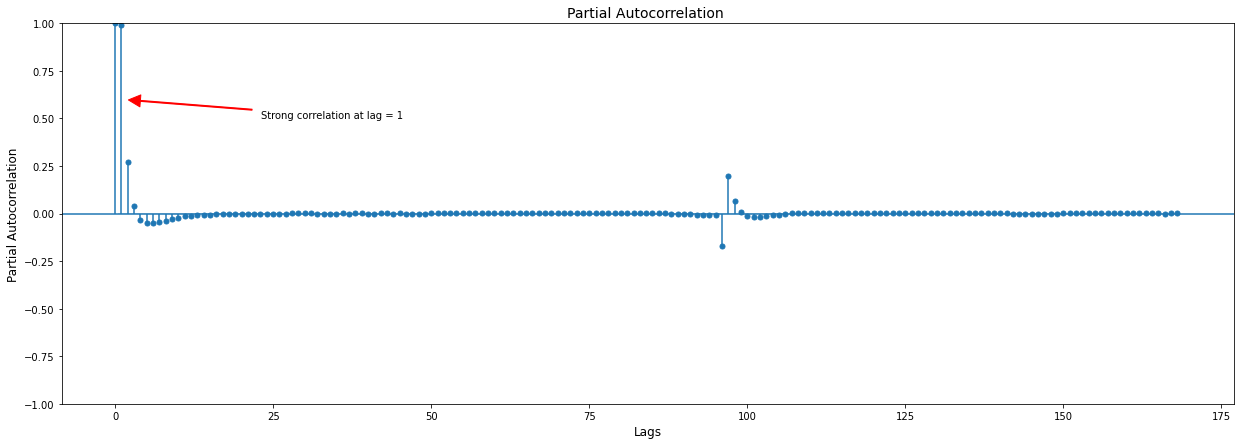

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf
dataframe = wind_data.set_index('datetime')
plt.rc("figure", figsize=(21, 7))
plot_pacf(dataframe.power, lags=24*7)

plt.annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data', \
            xytext=(0.17, 0.75), textcoords='axes fraction', \
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.xlabel('Lags', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.title(f'Partial Autocorrelation ', fontsize=14)
plt.show()

`Autocorrelation`

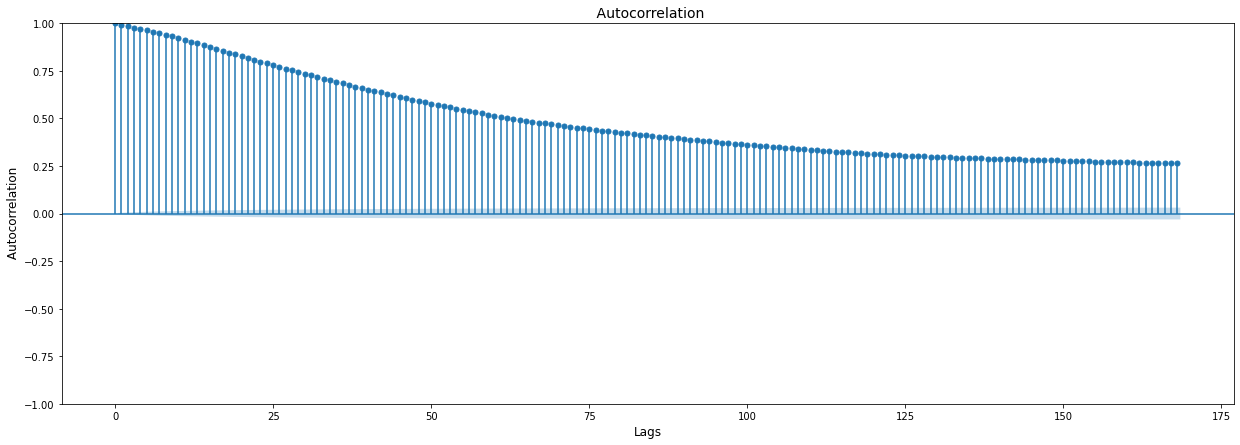

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
dataframe = wind_data.set_index('datetime')
plt.rc("figure", figsize=(21, 7))
plot_acf(dataframe.power, lags=24*7)
plt.xlabel('Lags', fontsize=12)
plt.ylabel(' Autocorrelation', fontsize=12)
plt.title(f' Autocorrelation', fontsize=14)
plt.show()

<span style="color:#228b22;background-color:white;font-size:22px">Correlation</span>  <br>

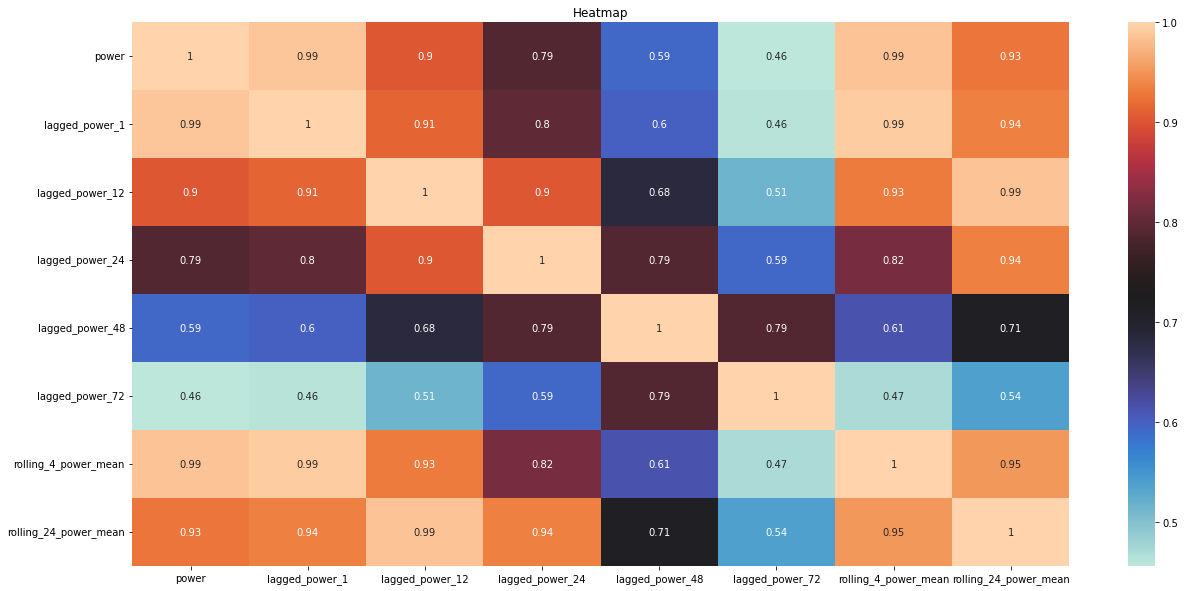

In [30]:
cor = wind_data.filter(regex='power').corr()
fig,axes = plt.subplots(1,1,figsize=(21,10))
sns.heatmap(cor,annot=True, cmap ='icefire')
plt.title('Heatmap')
plt.show()

<span style="color:#FF0000;background-color:white;font-size:15px">Observation</span> <br> 
* The lagged_power_1 , lagged_power_12 , rolling_4_power_mean , rolling_24_power_mean are the features highly correlated to power feature. 
* For every 12 timeblocks the power generated trend is similar across the years.

In [31]:
print(f'All the features are {wind_data.columns}')

All the features are Index(['datetime', 'power', 'tb', 'weekday', 'month', 'year', 'hour',
       'IQR_OUTLIER_FLAG', 'feat_monthName', 'feat_isNight', 'feat_isDawn',
       'feat_isMorning', 'feat_isAfternoon', 'lagged_power_1',
       'lagged_power_12', 'lagged_power_24', 'lagged_power_48',
       'lagged_power_72', 'rolling_4_power_mean', 'rolling_24_power_mean'],
      dtype='object')


<h2 style="color:#228b22;background-color:white;font-size:22px">Modelling</h2> <br> <a id=6></a>

**Forecasting target variable 8 timeblocks ahead** <br>
The `target ahead timeblocks` is 8. To forecast for 2 hours ahead => `2*4 = 8 timeblocks`.

In [32]:
train_data = pd.DataFrame()
target_ahead_timeblocks = 8 # forecasting 2 hours ahead. 
wind_data['ramp'] = wind_data['power'] - wind_data['power'].shift(target_ahead_timeblocks)
features = ['datetime', 'power','tb',\
        'feat_monthName', 'feat_isNight', 'feat_isDawn',\
       'feat_isMorning', 'feat_isAfternoon', 'lagged_power_1',\
       'lagged_power_12', 'lagged_power_24', 'lagged_power_48',\
       'lagged_power_72', 'rolling_4_power_mean', 'rolling_24_power_mean']
train_data = wind_data[features].copy()
for feature in train_data.columns:
    train_data[feature] = train_data[feature].shift(-target_ahead_timeblocks )
print(train_data.shape)
train_data.head()

(385566, 15)


,datetime,power,tb,feat_monthName,feat_isNight,feat_isDawn,feat_isMorning,feat_isAfternoon,lagged_power_1,lagged_power_12,lagged_power_24,lagged_power_48,lagged_power_72,rolling_4_power_mean,rolling_24_power_mean
0,2011-01-01 02:00:00,5509.0,9.0,1.0,0.0,1.0,0.0,0.0,5438.0,3416.0,3416.0,3416.0,3416.0,5240.25,4876.250000
1,2011-01-01 02:15:00,5638.0,10.0,1.0,0.0,1.0,0.0,0.0,5509.0,3416.0,3416.0,3416.0,3416.0,5368.00,4946.555556
2,2011-01-01 02:30:00,5582.0,11.0,1.0,0.0,1.0,0.0,0.0,5638.0,3416.0,3416.0,3416.0,3416.0,5481.50,5015.700000
3,2011-01-01 02:45:00,5792.0,12.0,1.0,0.0,1.0,0.0,0.0,5582.0,3416.0,3416.0,3416.0,3416.0,5541.75,5067.181818
4,2011-01-01 03:00:00,5962.0,13.0,1.0,0.0,1.0,0.0,0.0,5792.0,3416.0,3416.0,3416.0,3416.0,5630.25,5127.583333


In [33]:
train_data['target'] = train_data['power'].shift(-target_ahead_timeblocks)

<span style="color:#228b22;background-color:white;font-size:22px">Data Split</span> <a id=2></a> <br> 

The dataset is split using the 
* Training datetime is `2011-01-01 00:00:00` to `2021-12-31 07:45:00`
* `cutoff` datetime for validation data is `2021-01-01` to `2021-06-01`
* `cutoff` datetime for Test data is `2021-06-01` to `2021-12-30`

In [34]:
valid_cutoff_date = '2021-01-01 00:00:00' # Validation Cut Off
test_cutoff = '2021-06-01 00:00:00'  # Test Cut off 
x = train_data.drop('target',1).copy()
y = train_data[['datetime','target']].copy()

In [35]:
x_train = x[x['datetime'] < valid_cutoff_date].iloc[:,1:].copy()
y_train = y[y['datetime'] < valid_cutoff_date].iloc[:,1:].copy()
x_val = x[(x['datetime']>= valid_cutoff_date) & (x['datetime']< test_cutoff)].iloc[:,1:].copy()
y_val = y[(y['datetime']>= valid_cutoff_date) & (y['datetime']< test_cutoff)].iloc[:,1:].copy()
x_test = x[x['datetime'] >= test_cutoff].iloc[:,1:].copy()
y_test = y[y['datetime'] >= test_cutoff].iloc[:,1:].copy()

In [36]:
print(f'x train: {x_train.shape}')
print(f'x validation: {x_val.shape}')
print(f'x test: {x_test.shape}')
print(f'y train: {y_train.shape}')
print(f'y validation: {y_val.shape}')
print(f'y test: {y_test.shape}')

x train: (350678, 14)
x validation: (14492, 14)
x test: (20388, 14)
y train: (350678, 1)
y validation: (14492, 1)
y test: (20388, 1)


<span style="color:#228b22;background-color:white;font-size:22px">Performance metrics</span> <a id=2></a> <br>  

In [37]:
def regression_metrics(y_test,y_pred):
    print("MAE:\t",round(mean_absolute_error(y_test,y_pred),4))
    print("MSE:\t",round(mean_squared_error(y_test,y_pred),4))
    print("RMSE:\t",round(np.sqrt(mean_squared_error(y_test,y_pred)),4))

<span style="color:#228b22;background-color:white;font-size:22px">Cross Validation - GridSearchCV</span> <a id=6.1></a> <br>  

In [38]:
def model_validate(model, param_grid, x_train, y_train, x_test,y_test, model_name, k_folds=4, scoring='neg_mean_squared_error', fit_parameters={}):

    model_cv = GridSearchCV(model, param_grid, cv=k_folds, verbose=False, scoring= scoring, refit=True)
    model_cv.fit(x_train, y_train, **fit_parameters)
    y_train_pred = model_cv.predict(x_train)
    y_test_pred = model_cv.predict(x_test)

    print('Mean Squared Error = ', np.abs(model_cv.score(x_train, y_train)))
    print("Training metrics:")
    regression_metrics(y_train ,y_train_pred)
    
    return model_cv

<span style="color:#228b22;background-color:white;font-size:22px">Lasso</span> <a id=6.1.1></a> <br> 

In [39]:
lasso = Lasso(alpha =0.0005, random_state=20)
param_grid = [{'alpha':[0.0005,0.001, 0.005, 0.01, 0.05, 0.03, 0.1, 0.5, 1]}]

lasso_model = model_validate(lasso, param_grid, x_train, y_train, x_test, y_test, 'Lasso',k_folds=5)

Mean Squared Error =  982546.0166047069
Training metrics:
MAE:	 572.5387
MSE:	 982546.0166
RMSE:	 991.2346


<span style="color:#228b22;background-color:white;font-size:22px">LightGBM</span> <a id=6.2></a> <br> 

In [40]:
param_grid = {'learning_rate':[0.1], 'num_iterations': [10000], 'n_estimators': [25], 'num_leaves': [40],'verbose': [-1],'colsample_bytree':[0.4], 'subsample': [0.4], 'max_depth': [9]} 
lgb_model = lgr()

In [41]:
model_lgb = model_validate(lgb_model, param_grid, x_train, y_train, x_test, y_test, 'LGBM', fit_parameters={'eval_set':[(x_val, y_val)], 'eval_metric':'rmse'})

[1]	valid_0's rmse: 3242.18	valid_0's l2: 1.05118e+07
[2]	valid_0's rmse: 3011.61	valid_0's l2: 9.06979e+06
[3]	valid_0's rmse: 2763.79	valid_0's l2: 7.63854e+06
[4]	valid_0's rmse: 2544.77	valid_0's l2: 6.47587e+06
[5]	valid_0's rmse: 2352	valid_0's l2: 5.5319e+06
[6]	valid_0's rmse: 2182.82	valid_0's l2: 4.7647e+06
[7]	valid_0's rmse: 2043	valid_0's l2: 4.17385e+06
[8]	valid_0's rmse: 1948.02	valid_0's l2: 3.79477e+06
[9]	valid_0's rmse: 1837.94	valid_0's l2: 3.37802e+06
[10]	valid_0's rmse: 1774.57	valid_0's l2: 3.14909e+06
[11]	valid_0's rmse: 1690.55	valid_0's l2: 2.85795e+06
[12]	valid_0's rmse: 1611.74	valid_0's l2: 2.59769e+06
[13]	valid_0's rmse: 1575.25	valid_0's l2: 2.48142e+06
[14]	valid_0's rmse: 1514.2	valid_0's l2: 2.29281e+06
[15]	valid_0's rmse: 1508.02	valid_0's l2: 2.27413e+06
[16]	valid_0's rmse: 1457.17	valid_0's l2: 2.12334e+06
[17]	valid_0's rmse: 1419.66	valid_0's l2: 2.01543e+06
[18]	valid_0's rmse: 1386.01	valid_0's l2: 1.92103e+06
[19]	valid_0's rmse: 1357.83

<span style="color:#228b22;background-color:white;font-size:22px">CatBoost</span> <a id=6.3></a> <br> 

In [42]:
cat = cbr(loss_function='RMSE',learning_rate=0.01,max_depth=7,iterations=1500) 

catreg = cat.fit(x_train,y_train,verbose_eval=200,plot=True,eval_set=(x_val,y_val))
print('Model trained for horizon {}'.format(target_ahead_timeblocks))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2965.4943142	test: 3588.5520445	best: 3588.5520445 (0)	total: 101ms	remaining: 2m 31s
200:	learn: 1078.9876460	test: 1331.6880183	best: 1331.6880183 (200)	total: 6.14s	remaining: 39.7s
400:	learn: 975.0089868	test: 1192.4031416	best: 1192.4031416 (400)	total: 12.3s	remaining: 33.6s
600:	learn: 955.1279912	test: 1168.5907904	best: 1168.5907904 (600)	total: 18.6s	remaining: 27.8s
800:	learn: 942.3158488	test: 1156.0018793	best: 1156.0018793 (800)	total: 24.6s	remaining: 21.4s
1000:	learn: 932.2864074	test: 1147.8502635	best: 1147.8502635 (1000)	total: 30.8s	remaining: 15.4s
1200:	learn: 923.8900954	test: 1141.4377750	best: 1141.4377750 (1200)	total: 36.8s	remaining: 9.15s
1400:	learn: 916.3247809	test: 1138.7343051	best: 1137.9870688 (1390)	total: 43s	remaining: 3.04s
1499:	learn: 912.9159064	test: 1137.0346270	best: 1137.0346270 (1499)	total: 46s	remaining: 0us

bestTest = 1137.034627
bestIteration = 1499

Model trained for horizon 8


**Output**

In [43]:
predictions= lasso_model.predict(x_test)
y_test['lasso_prediction'] = predictions
predictions= model_lgb.predict(x_test)
y_test['light_gbm_prediction'] = predictions
predictions= catreg.predict(x_test)
y_test['cat_boost_prediction']=predictions

<span style="color:#228b22;background-color:white;font-size:22px">Forecasted results</span> <a id=6.4></a> <br> 

Shifting back the time forecast power values by `8 timeblocks`

In [44]:
y_test.target = y_test.target.shift(target_ahead_timeblocks)

In [45]:
y_test[len(y_test)-target_ahead_timeblocks:len(y_test)]

,target,lasso_prediction,light_gbm_prediction,cat_boost_prediction
385550,8530.69,8833.917257,8716.821058,8804.113192
385551,8603.80,8608.278137,9373.640479,9102.368931
385552,8412.88,8390.543853,8695.558661,8628.545292
385553,8140.31,8061.277242,8668.624029,8413.447849
385554,8162.33,8086.428669,8509.721584,8337.480996
385555,8405.11,8298.523814,8936.165254,8421.339562
385556,8503.48,8447.385742,9223.549728,8656.882430
385557,8403.53,8358.888804,8860.933219,8411.806811


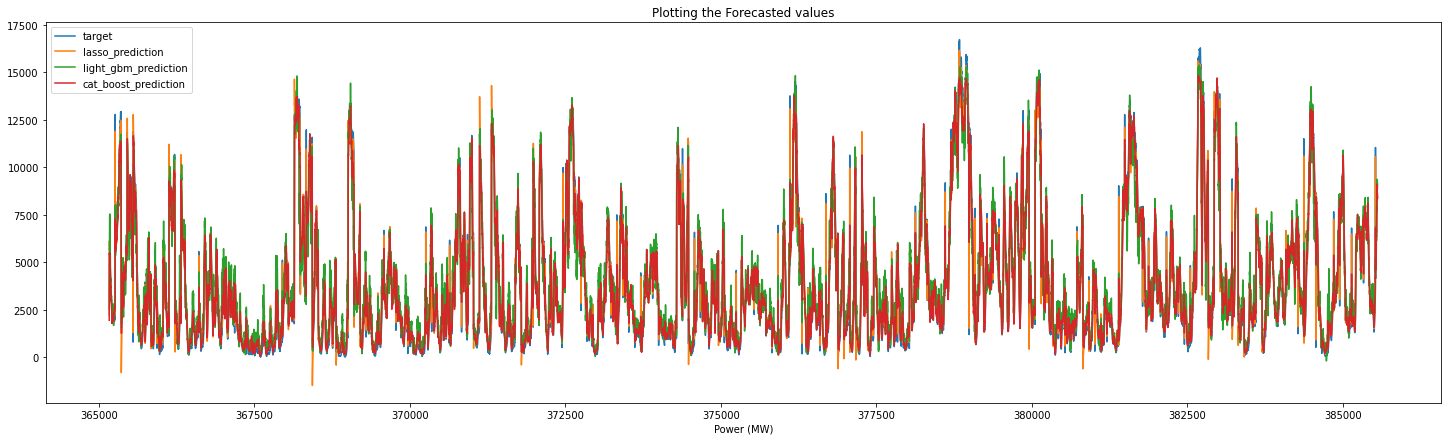

In [46]:
fig,axes = plt.subplots(1,1,figsize=(25,7))
y_test.plot(ax=axes)
plt.title('Plotting the Forecasted values')
plt.xlabel('Power (MW)')
plt.show()

**Plotting Forecasted results 2 hours(8 tb ahead).**

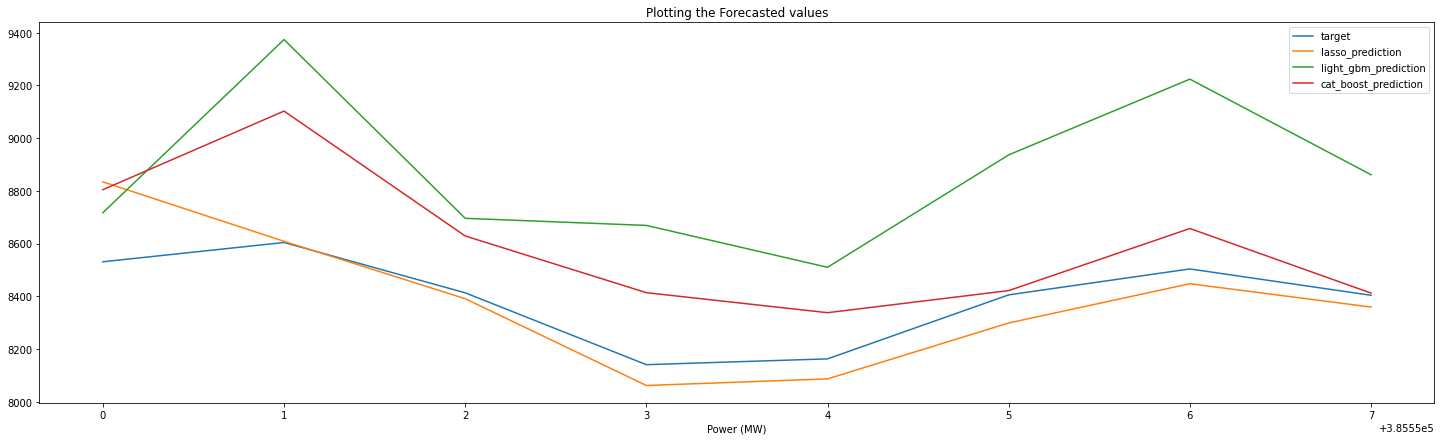

In [47]:
fig,axes = plt.subplots(1,1,figsize=(25,7))
y_test[len(y_test)-target_ahead_timeblocks:len(y_test)].plot(ax=axes)
plt.title('Plotting the Forecasted values')
plt.xlabel('Power (MW)')
plt.show()

### Thanks for going through the notebook. Please share your feedback and upvote if you like it. <br>
-Thanks `@tejasurya` 